<a href="https://colab.research.google.com/github/MRsources/Article_MAGMA24_RMRI/blob/main/Fig4_TSE_2Dre-implementation/Fig_4_TSE_2D_re-implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypulseq==1.4.2 &> /dev/null
!pip install MRzeroCore==0.3.12 &> /dev/null
# numpy version 1.26.4 , matplotlib version 3.8.0, torch version 2.5.1+cu121
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

# 2D TSE
The basic idea is to reimplement a TSE seqeunce just from the below given sequence diagram.

<img src="https://github.com/MRsources/Article_MAGMA24_RMRI/blob/main/figures/Fig_2_TSE_RR.png?raw=true" width="360">


We assume TE=10 ms, slice thickness of 50 mm.

As the information of the rf and ADC phases is not given, we assume in a) that they are 0. This leads to a N/2 image shift due to the soin echo having alternating sign, and image artifacts.

b) resolves the N/2 shift, by alternating also the ADC phase, but the artifacts from the instable TSE version without rf phase shift perists.

c) has the correct rf and adc phase, but the readout spoilers rspoil ar set to zero. This can lead to a high frequency artifact due to an FID contributio visible in the k-space plot.
To see this artifact clearly, we reduced the flipangles from 90°-180°  to 50°-100° in Figure c), this is equivalent to a too low B1+ by 5/9, i.e. if the reference voltage is set lower for SAR reasons.
To see the effects of the missing readout spoilers the relatively large slice thickness is needed, otherwise the slice selection gradient spoils away the FID artifact here.

d) correct phases and spoilers, but wrong reordering

e) the possibly correct implementation


For better contrast visualization we also added a Inversion pulse and a delay of 4s before the single shot TSE readout, this lowers the CSF signal and makes the GM/WM contrast better visible; you can switch this off by setting TI=0.

/usr/local/lib/python3.11/dist-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


 TE [ms] 10.0
Timing check passed successfully
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 66 / 66 - done


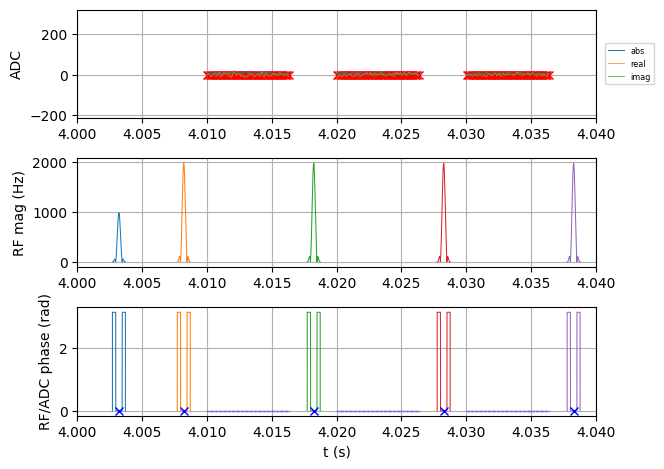

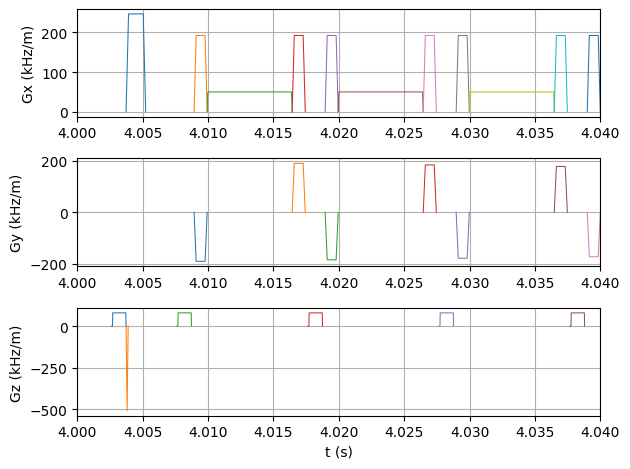

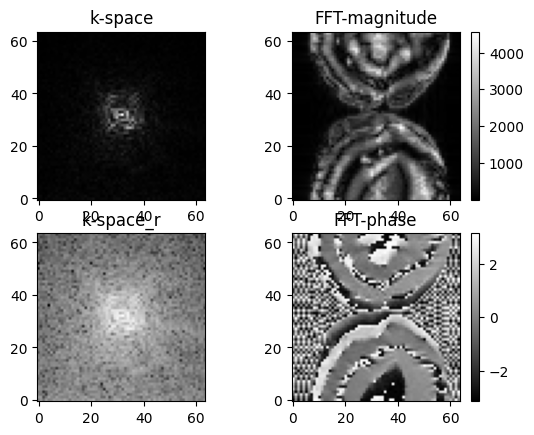

In [2]:
#@title Fig 4a) TSE without rfex phase shift

base_resolution= 64 # @param {type: "slider", min: 2, max: 112,step:2}
TE_ms=10 # @param {type: "slider", min: 0.0, max: 200.0}
TE=TE_ms*1e-3
TI_s=4 # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
Excitation_FA=90 # @param {type: "slider", min: 10, max: 270}
Excitation_phase=0 # @param {type: "slider", min: 0, max: 270,step:10}
ADC_phase='same as rfex' # @param ['same as rfex','alternating']
Refocusing_FA=180 # @param {type: "slider", min: 10, max: 270}
Refocusing_phase=0 # @param {type: "slider", min: 0, max: 270,step:10}
r_spoil =1 # @param {type: "slider", min: 0, max: 3}
PEtype = 'linear' # @param ['centric', 'linear']
PE_grad_on=True # @param {type: "boolean"}
RO_grad_on=True # @param {type: "boolean"}

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypulseq as pp
import MRzeroCore as mr0

# %% S1. SETUP sys
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

seq = pp.Sequence(system)
# Define FOV and resolution
fov = 200e-3
slice_thickness = 50e-3

Nread  = base_resolution  # frequency encoding steps/samples
Nphase = base_resolution  # phase encoding steps/samples


# Define rf events
rf1, gz1, gzr1 = pp.make_sinc_pulse(
    flip_angle=Excitation_FA * np.pi / 180, phase_offset=Excitation_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

rf2, gz2, _ = pp.make_sinc_pulse(
    flip_angle=Refocusing_FA* np.pi / 180, phase_offset=Refocusing_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

dwell=50e-6*2

G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', rise_time = 0.5*dwell, flat_area=Nread / fov*G_flag[0], flat_time=Nread*dwell, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=rf1.phase_offset, delay=0*gx.rise_time, system=system)
gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), duration=1e-3, system=system)
gp = pp.make_trapezoid(channel='y', area=0 / fov, duration=1e-3, system=system)
rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)

if PEtype == 'centric':
      phenc = np.asarray([i // 2 if i % 2 == 0 else -(i + 1) // 2 for i in range(Nphase)]) / fov
else:
      phenc = np.arange(-Nphase // 2, Nphase // 2) / fov

# the minimal TE is given by one full period form ref pulse to ref pulse, thus gz2+gx+2*gp
minTE2=(pp.calc_duration(gz2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2

minTE2=round(minTE2/10e-5)*10e-5


# to realize longer TE,  we introduce a TEdelay that is added before and afetr the encoding period
TEd=round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time

if TEd==0:
  print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
else:
  print(' TE [ms]', 2*(minTE2 +TEd)*1000)


# FLAIR
if TI_s>0:
  seq.add_block(rf_prep)
  seq.add_block(gx_pre0)
  seq.add_block(pp.make_delay(TI_s))


seq.add_block(rf1,gz1)
seq.add_block(gx_pre0,gzr1)

# last timing step is to add TE/2 also between excitation and first ref pulse
# from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(gz1)-pp.calc_duration(gx_pre0)))

for ii, encoding in enumerate(phenc):  # e.g. -64:63
    gp  = pp.make_trapezoid(channel='y', area=+encoding*G_flag[1], duration=1e-3, system=system)
    gp_ = pp.make_trapezoid(channel='y', area=-encoding*G_flag[1], duration=1e-3, system=system)

    seq.add_block(rf2,gz2)
    seq.add_block(pp.make_delay(TEd)) # TE delay
    seq.add_block(gx_prewinder, gp)
    if ADC_phase=='alternating':
      adc.phase_offset+=np.pi
    seq.add_block(adc, gx)
    seq.add_block(gx_prewinder, gp_)
    seq.add_block(pp.make_delay(TEd)) # TE delay

# %% S2. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]


# %% S3 quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False,time_range=(TI_s,TI_s+4*TE))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'TSE_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
sort_ids = np.argsort(phenc) # sort phase encoding
kspace = kspace[:,sort_ids]  # reorder kspace data
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()),cmap='gray')
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())),cmap='gray')

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()),cmap='gray')
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi,cmap='gray')
plt.colorbar()

# save for final plot
Fig_img_abcde=np.zeros((5,Nread,Nphase))
Fig_img_abcde[0]=np.abs(space.numpy())
Fig_img_fghi=np.zeros((5,Nread,Nphase))
Fig_img_fghi[0]=np.log(np.abs(kspace.numpy()))

 TE [ms] 10.0
Timing check passed successfully
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 66 / 66 - done


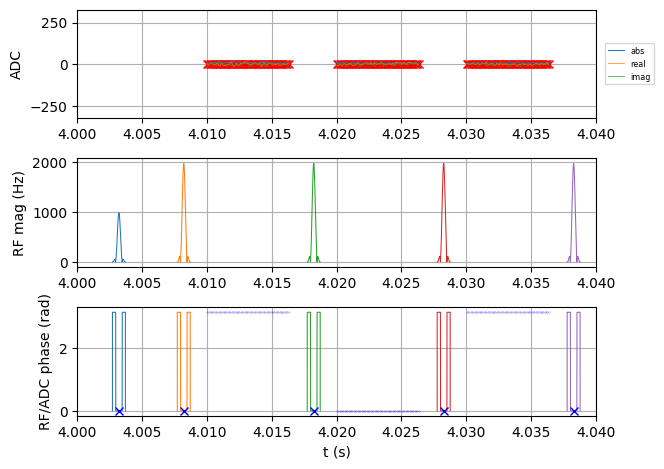

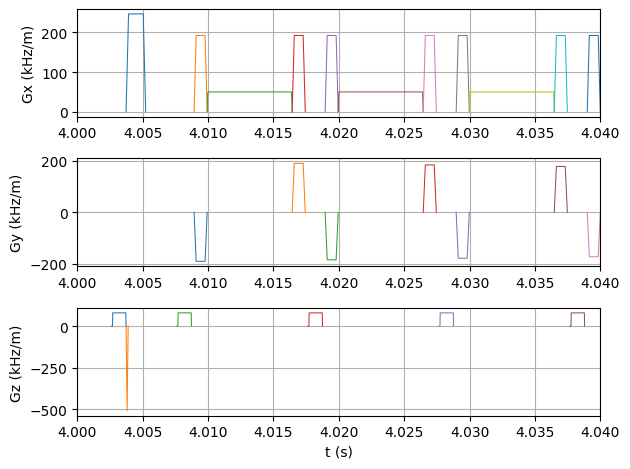

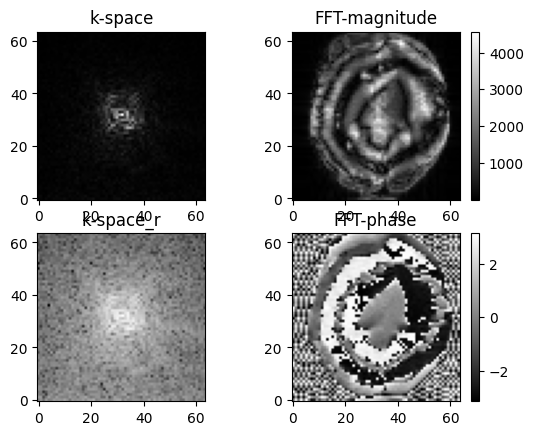

In [3]:
#@title Fig 4b) TSE without rf phase, ADC alternating

base_resolution= 64 # @param {type: "slider", min: 2, max: 112,step:2}
TE_ms=10 # @param {type: "slider", min: 0.0, max: 200.0}
TE=TE_ms*1e-3
TI_s=4 # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
Excitation_FA=90 # @param {type: "slider", min: 10, max: 270}
Excitation_phase=0 # @param {type: "slider", min: 0, max: 270,step:10}
ADC_phase='alternating' # @param ['same as rfex','alternating']
Refocusing_FA=180 # @param {type: "slider", min: 10, max: 270}
Refocusing_phase=0 # @param {type: "slider", min: 0, max: 270,step:10}
r_spoil =1 # @param {type: "slider", min: 0, max: 3}
PEtype = 'linear' # @param ['centric', 'linear']
PE_grad_on=True # @param {type: "boolean"}
RO_grad_on=True # @param {type: "boolean"}

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypulseq as pp
import MRzeroCore as mr0

# %% S1. SETUP sys
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

seq = pp.Sequence(system)
# Define FOV and resolution
fov = 200e-3
slice_thickness = 50e-3

Nread  = base_resolution  # frequency encoding steps/samples
Nphase = base_resolution  # phase encoding steps/samples


# Define rf events
rf1, gz1, gzr1 = pp.make_sinc_pulse(
    flip_angle=Excitation_FA * np.pi / 180, phase_offset=Excitation_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

rf2, gz2, _ = pp.make_sinc_pulse(
    flip_angle=Refocusing_FA* np.pi / 180, phase_offset=Refocusing_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

dwell=50e-6*2

G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', rise_time = 0.5*dwell, flat_area=Nread / fov*G_flag[0], flat_time=Nread*dwell, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=rf1.phase_offset, delay=0*gx.rise_time, system=system)
gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), duration=1e-3, system=system)
gp = pp.make_trapezoid(channel='y', area=0 / fov, duration=1e-3, system=system)
rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)

if PEtype == 'centric':
      phenc = np.asarray([i // 2 if i % 2 == 0 else -(i + 1) // 2 for i in range(Nphase)]) / fov
else:
      phenc = np.arange(-Nphase // 2, Nphase // 2) / fov


# the minimal TE is given by one full period form ref pulse to ref pulse, thus gz2+gx+2*gp
minTE2=(pp.calc_duration(gz2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2

minTE2=round(minTE2/10e-5)*10e-5


# to realize longer TE,  we introduce a TEdelay that is added before and afetr the encoding period
TEd=round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time

if TEd==0:
  print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
else:
  print(' TE [ms]', 2*(minTE2 +TEd)*1000)


# FLAIR
if TI_s>0:
  seq.add_block(rf_prep)
  seq.add_block(gx_pre0)
  seq.add_block(pp.make_delay(TI_s))

seq.add_block(rf1,gz1)
seq.add_block(gx_pre0,gzr1)


# last timing step is to add TE/2 also between excitation and first ref pulse
# from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(gz1)-pp.calc_duration(gx_pre0)))

for ii, encoding in enumerate(phenc):  # e.g. -64:63
    gp  = pp.make_trapezoid(channel='y', area=+encoding*G_flag[1], duration=1e-3, system=system)
    gp_ = pp.make_trapezoid(channel='y', area=-encoding*G_flag[1], duration=1e-3, system=system)

    seq.add_block(rf2,gz2)
    seq.add_block(pp.make_delay(TEd)) # TE delay
    seq.add_block(gx_prewinder, gp)
    if ADC_phase=='alternating':
      adc.phase_offset+=np.pi
    seq.add_block(adc, gx)
    seq.add_block(gx_prewinder, gp_)
    seq.add_block(pp.make_delay(TEd)) # TE delay

# %% S2. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]


# %% S3 quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False,time_range=(TI_s,TI_s+4*TE))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'TSE_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
sort_ids = np.argsort(phenc) # sort phase encoding
kspace = kspace[:,sort_ids]  # reorder kspace data
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()),cmap='gray')
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())),cmap='gray')

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()),cmap='gray')
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi,cmap='gray')
plt.colorbar()

# save for final plot
Fig_img_abcde[1]=np.abs(space.numpy())
Fig_img_fghi[1]=np.log(np.abs(kspace.numpy()))

 TE [ms] 10.0
Timing check passed successfully
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 66 / 66 - done


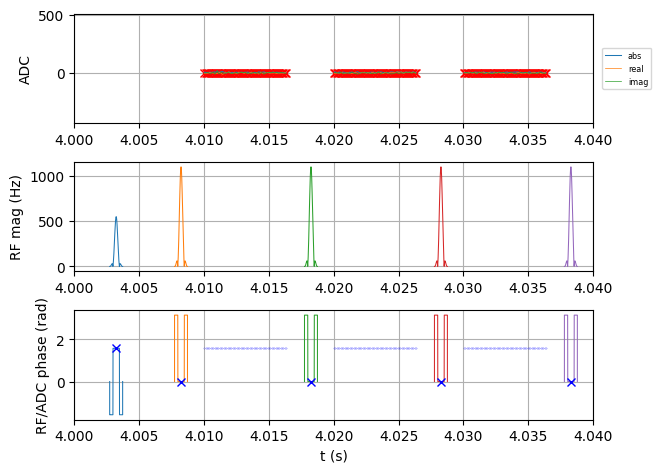

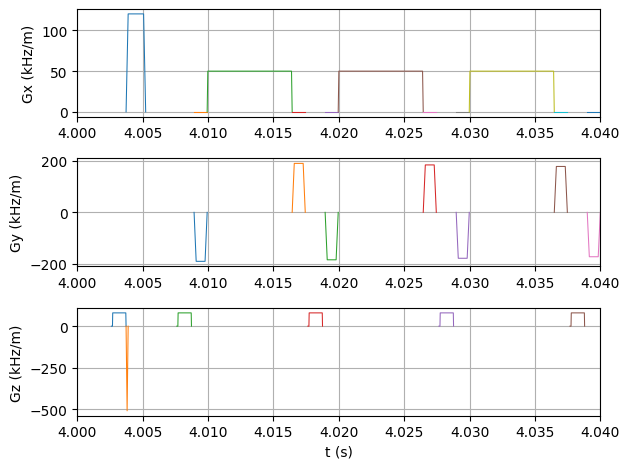

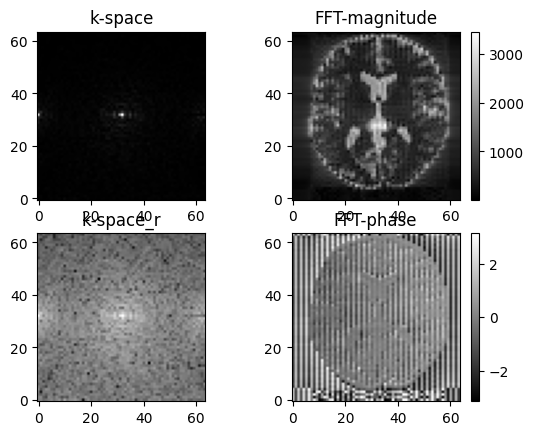

In [4]:
#@title Fig 4c) TSE without readout spoilers, 50°-100°

base_resolution= 64 # @param {type: "slider", min: 2, max: 112,step:2}
TE_ms=10 # @param {type: "slider", min: 0.0, max: 200.0}
TE=TE_ms*1e-3
TI_s=4 # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
Excitation_FA=50 # @param {type: "slider", min: 10, max: 270}
Excitation_phase=90 # @param {type: "slider", min: 0, max: 270,step:10}
ADC_phase='same as rfex' # @param ['same as rfex','alternating']
Refocusing_FA=100 # @param {type: "slider", min: 10, max: 270}
Refocusing_phase=0 # @param {type: "slider", min: 0, max: 270,step:10}
r_spoil =0 # @param {type: "slider", min: 0, max: 3}
PEtype = 'linear' # @param ['centric', 'linear']
PE_grad_on=True # @param {type: "boolean"}
RO_grad_on=True # @param {type: "boolean"}

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypulseq as pp
import MRzeroCore as mr0

# %% S1. SETUP sys
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

seq = pp.Sequence(system)
# Define FOV and resolution
fov = 200e-3
slice_thickness = 50e-3

Nread  = base_resolution  # frequency encoding steps/samples
Nphase = base_resolution  # phase encoding steps/samples


# Define rf events
rf1, gz1, gzr1 = pp.make_sinc_pulse(
    flip_angle=Excitation_FA * np.pi / 180, phase_offset=Excitation_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

rf2, gz2, _ = pp.make_sinc_pulse(
    flip_angle=Refocusing_FA* np.pi / 180, phase_offset=Refocusing_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

dwell=50e-6*2

G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', rise_time = 0.5*dwell, flat_area=Nread / fov*G_flag[0], flat_time=Nread*dwell, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=rf1.phase_offset, delay=0*gx.rise_time, system=system)
gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), duration=1e-3, system=system)
gp = pp.make_trapezoid(channel='y', area=0 / fov, duration=1e-3, system=system)
rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)

if PEtype == 'centric':
      phenc = np.asarray([i // 2 if i % 2 == 0 else -(i + 1) // 2 for i in range(Nphase)]) / fov
else:
      phenc = np.arange(-Nphase // 2, Nphase // 2) / fov

# the minimal TE is given by one full period form ref pulse to ref pulse, thus gz2+gx+2*gp
minTE2=(pp.calc_duration(gz2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2

minTE2=round(minTE2/10e-5)*10e-5


# to realize longer TE,  we introduce a TEdelay that is added before and afetr the encoding period
TEd=round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time

if TEd==0:
  print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
else:
  print(' TE [ms]', 2*(minTE2 +TEd)*1000)

# FLAIR
if TI_s>0:
  seq.add_block(rf_prep)
  seq.add_block(gx_pre0)
  seq.add_block(pp.make_delay(TI_s))


seq.add_block(rf1,gz1)
seq.add_block(gx_pre0,gzr1)


# last timing step is to add TE/2 also between excitation and first ref pulse
# from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(gz1)-pp.calc_duration(gx_pre0)))

for ii, encoding in enumerate(phenc):  # e.g. -64:63
    gp  = pp.make_trapezoid(channel='y', area=+encoding*G_flag[1], duration=1e-3, system=system)
    gp_ = pp.make_trapezoid(channel='y', area=-encoding*G_flag[1], duration=1e-3, system=system)

    seq.add_block(rf2,gz2)
    seq.add_block(pp.make_delay(TEd)) # TE delay
    seq.add_block(gx_prewinder, gp)
    if ADC_phase=='alternating':
      adc.phase_offset+=np.pi
    seq.add_block(adc, gx)
    seq.add_block(gx_prewinder, gp_)
    seq.add_block(pp.make_delay(TEd)) # TE delay

# %% S2. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]


# %% S3 quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False,time_range=(TI_s,TI_s+4*TE))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'TSE_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
sort_ids = np.argsort(phenc) # sort phase encoding
kspace = kspace[:,sort_ids]  # reorder kspace data
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()),cmap='gray')
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())),cmap='gray')

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()),cmap='gray')
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi,cmap='gray')
plt.colorbar()

# save for final plot
Fig_img_abcde[2]=np.abs(space.numpy())
Fig_img_fghi[2]=np.log(np.abs(kspace.numpy()))

 TE [ms] 10.0
Timing check passed successfully
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 66 / 66 - done


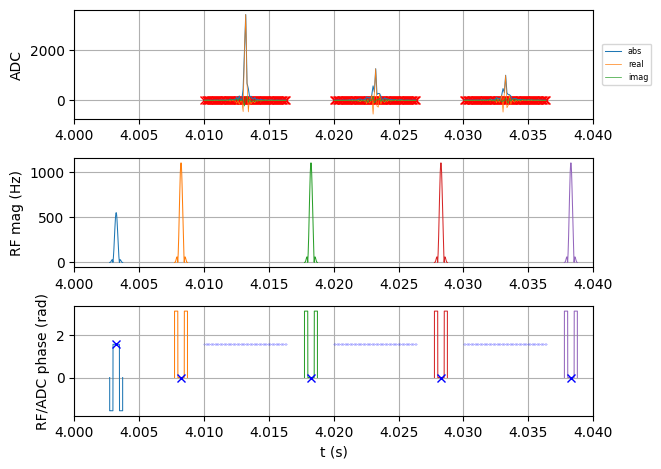

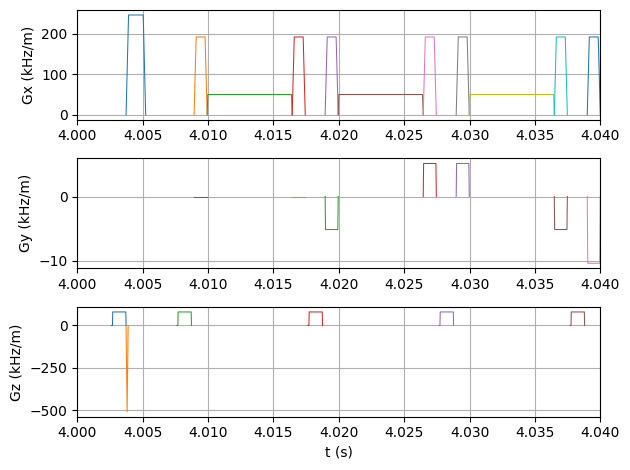

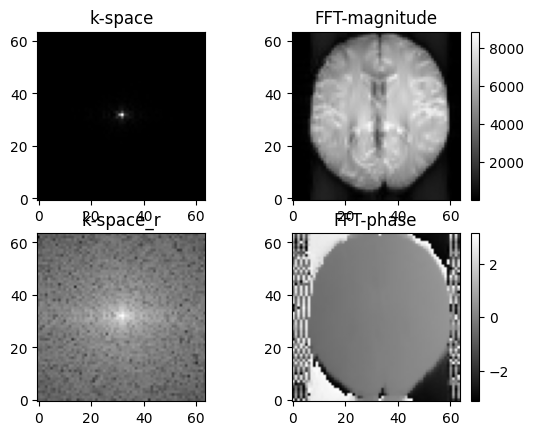

In [5]:
#@title Fig 4d) TSE with centric reordering

base_resolution= 64 # @param {type: "slider", min: 2, max: 112,step:2}
TE_ms=10 # @param {type: "slider", min: 0.0, max: 200.0}
TE=TE_ms*1e-3
TI_s=4 # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
Excitation_FA=50 # @param {type: "slider", min: 10, max: 270}
Excitation_phase=90 # @param {type: "slider", min: 0, max: 270,step:10}
ADC_phase='same as rfex' # @param ['same as rfex','alternating']
Refocusing_FA=100 # @param {type: "slider", min: 10, max: 270}
Refocusing_phase=0 # @param {type: "slider", min: 0, max: 270,step:10}
r_spoil =1 # @param {type: "slider", min: 0, max: 3}
PEtype = 'centric' # @param ['centric', 'linear']
PE_grad_on=True # @param {type: "boolean"}
RO_grad_on=True # @param {type: "boolean"}

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypulseq as pp
import MRzeroCore as mr0

# %% S1. SETUP sys
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

seq = pp.Sequence(system)
# Define FOV and resolution
fov = 200e-3
slice_thickness = 50e-3

Nread  = base_resolution  # frequency encoding steps/samples
Nphase = base_resolution  # phase encoding steps/samples


# Define rf events
rf1, gz1, gzr1 = pp.make_sinc_pulse(
    flip_angle=Excitation_FA * np.pi / 180, phase_offset=Excitation_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

rf2, gz2, _ = pp.make_sinc_pulse(
    flip_angle=Refocusing_FA* np.pi / 180, phase_offset=Refocusing_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

dwell=50e-6*2

G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', rise_time = 0.5*dwell, flat_area=Nread / fov*G_flag[0], flat_time=Nread*dwell, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=rf1.phase_offset, delay=0*gx.rise_time, system=system)
gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), duration=1e-3, system=system)
gp = pp.make_trapezoid(channel='y', area=0 / fov, duration=1e-3, system=system)
rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)

if PEtype == 'centric':
      phenc = np.asarray([i // 2 if i % 2 == 0 else -(i + 1) // 2 for i in range(Nphase)]) / fov
else:
      phenc = np.arange(-Nphase // 2, Nphase // 2) / fov

# the minimal TE is given by one full period form ref pulse to ref pulse, thus gz2+gx+2*gp
minTE2=(pp.calc_duration(gz2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2

minTE2=round(minTE2/10e-5)*10e-5


# to realize longer TE,  we introduce a TEdelay that is added before and afetr the encoding period
TEd=round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time

if TEd==0:
  print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
else:
  print(' TE [ms]', 2*(minTE2 +TEd)*1000)



# FLAIR
if TI_s>0:
  seq.add_block(rf_prep)
  seq.add_block(gx_pre0)
  seq.add_block(pp.make_delay(TI_s))

seq.add_block(rf1,gz1)
seq.add_block(gx_pre0,gzr1)


# last timing step is to add TE/2 also between excitation and first ref pulse
# from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(gz1)-pp.calc_duration(gx_pre0)))

for ii, encoding in enumerate(phenc):  # e.g. -64:63
    gp  = pp.make_trapezoid(channel='y', area=+encoding*G_flag[1], duration=1e-3, system=system)
    gp_ = pp.make_trapezoid(channel='y', area=-encoding*G_flag[1], duration=1e-3, system=system)

    seq.add_block(rf2,gz2)
    seq.add_block(pp.make_delay(TEd)) # TE delay
    seq.add_block(gx_prewinder, gp)
    if ADC_phase=='alternating':
      adc.phase_offset+=np.pi
    seq.add_block(adc, gx)
    seq.add_block(gx_prewinder, gp_)
    seq.add_block(pp.make_delay(TEd)) # TE delay

# %% S2. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]


# %% S3 quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False,time_range=(TI_s,4+4*TE))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'TSE_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
sort_ids = np.argsort(phenc) # sort phase encoding
kspace = kspace[:,sort_ids]  # reorder kspace data
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()),cmap='gray')
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())),cmap='gray')

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()),cmap='gray')
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi,cmap='gray')
plt.colorbar()

# save for final plot
Fig_img_abcde[3]=np.abs(space.numpy())
Fig_img_fghi[3]=np.log(np.abs(kspace.numpy()))

 TE [ms] 10.0
Timing check passed successfully
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 66 / 66 - done


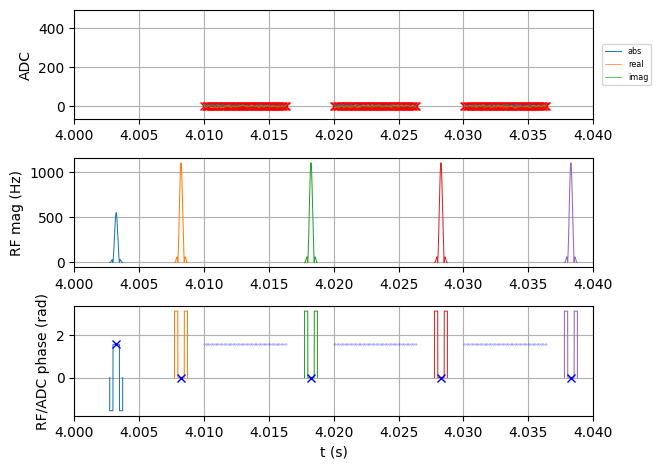

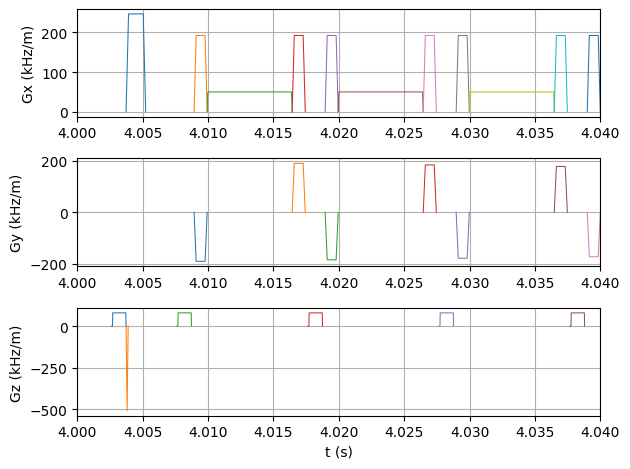

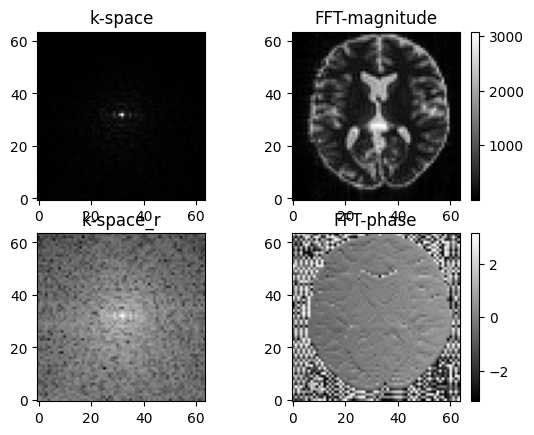

In [6]:
#@title Fig 4d) correct TSE, 50°-100°

base_resolution= 64 # @param {type: "slider", min: 2, max: 112,step:2}
TE_ms=10 # @param {type: "slider", min: 0.0, max: 200.0}
TE=TE_ms*1e-3
TI_s=4 # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
Excitation_FA=50 # @param {type: "slider", min: 10, max: 270}
Excitation_phase=90 # @param {type: "slider", min: 0, max: 270,step:10}
ADC_phase='same as rfex' # @param ['same as rfex','alternating']
Refocusing_FA=100 # @param {type: "slider", min: 10, max: 270}
Refocusing_phase=0 # @param {type: "slider", min: 0, max: 270,step:10}
r_spoil =1 # @param {type: "slider", min: 0, max: 3}
PEtype = 'linear' # @param ['centric', 'linear']
PE_grad_on=True # @param {type: "boolean"}
RO_grad_on=True # @param {type: "boolean"}

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypulseq as pp
import MRzeroCore as mr0

# %% S1. SETUP sys
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

seq = pp.Sequence(system)
# Define FOV and resolution
fov = 200e-3
slice_thickness = 50e-3

Nread  = base_resolution  # frequency encoding steps/samples
Nphase = base_resolution  # phase encoding steps/samples


# Define rf events
rf1, gz1, gzr1 = pp.make_sinc_pulse(
    flip_angle=Excitation_FA * np.pi / 180, phase_offset=Excitation_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

rf2, gz2, _ = pp.make_sinc_pulse(
    flip_angle=Refocusing_FA* np.pi / 180, phase_offset=Refocusing_phase * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

dwell=50e-6*2

G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', rise_time = 0.5*dwell, flat_area=Nread / fov*G_flag[0], flat_time=Nread*dwell, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=rf1.phase_offset, delay=0*gx.rise_time, system=system)
gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), duration=1e-3, system=system)
gp = pp.make_trapezoid(channel='y', area=0 / fov, duration=1e-3, system=system)
rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)

if PEtype == 'centric':
      phenc = np.asarray([i // 2 if i % 2 == 0 else -(i + 1) // 2 for i in range(Nphase)]) / fov
else:
      phenc = np.arange(-Nphase // 2, Nphase // 2) / fov

# the minimal TE is given by one full period form ref pulse to ref pulse, thus gz2+gx+2*gp
minTE2=(pp.calc_duration(gz2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2

minTE2=round(minTE2/10e-5)*10e-5


# to realize longer TE,  we introduce a TEdelay that is added before and afetr the encoding period
TEd=round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time

if TEd==0:
  print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
else:
  print(' TE [ms]', 2*(minTE2 +TEd)*1000)


# FLAIR
if TI_s>0:
  seq.add_block(rf_prep)
  seq.add_block(gx_pre0)
  seq.add_block(pp.make_delay(TI_s))


seq.add_block(rf1,gz1)
seq.add_block(gx_pre0,gzr1)

# last timing step is to add TE/2 also between excitation and first ref pulse
# from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(gz1)-pp.calc_duration(gx_pre0)))

for ii, encoding in enumerate(phenc):  # e.g. -64:63
    gp  = pp.make_trapezoid(channel='y', area=+encoding*G_flag[1], duration=1e-3, system=system)
    gp_ = pp.make_trapezoid(channel='y', area=-encoding*G_flag[1], duration=1e-3, system=system)

    seq.add_block(rf2,gz2)
    seq.add_block(pp.make_delay(TEd)) # TE delay
    seq.add_block(gx_prewinder, gp)
    if ADC_phase=='alternating':
      adc.phase_offset+=np.pi
    seq.add_block(adc, gx)
    seq.add_block(gx_prewinder, gp_)
    seq.add_block(pp.make_delay(TEd)) # TE delay

# %% S2. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]


# %% S3 quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False,time_range=(TI_s,TI_s+4*TE))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'TSE_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
sort_ids = np.argsort(phenc) # sort phase encoding
kspace = kspace[:,sort_ids]  # reorder kspace data
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()),cmap='gray')
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())),cmap='gray')

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()),cmap='gray')
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi,cmap='gray')
plt.colorbar()

# save for final plot
Fig_img_abcde[4]=np.abs(space.numpy())
Fig_img_fghi[4]=np.log(np.abs(kspace.numpy()))

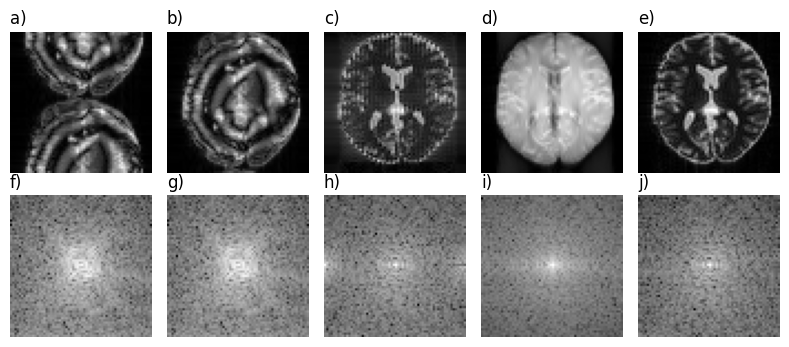

In [7]:
#@title Plot full Fig 4

plt.figure(figsize=(8, 3.5))  # Adjust figure size here (width, height)

lab1=['a)','b)','c)','d)','e)']
lab2=['f)','g)','h)','i)','j)']
# Iterate through the first dimension and plot each slice using mr0.util.imshow
for i in range(0,5):
    plt.subplot(2,5,i+1)
    mr0.util.imshow(Fig_img_abcde[i, :, :], cmap='gray')  # Use mr0.util.imshow
    plt.title(lab1[i],loc='left')
    plt.axis('off')  # Turn off axis ticks and labels

    plt.subplot(2,5,i+6)
    mr0.util.imshow(Fig_img_fghi[i, :, :], cmap='gray')  # Use mr0.util.imshow
    plt.title(lab2[i],loc='left')
    plt.axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()



Current time range: (3.95, 4.05)


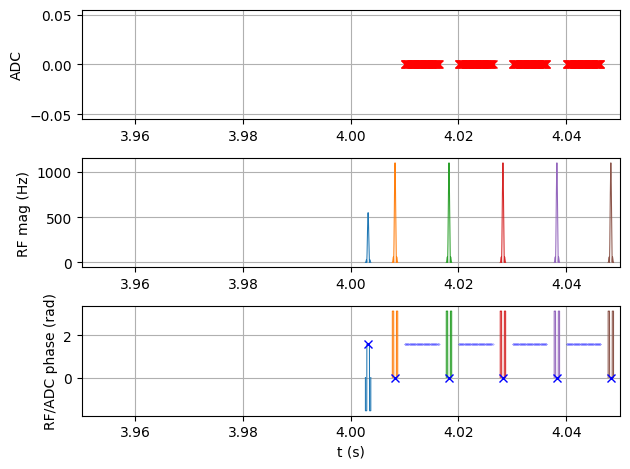

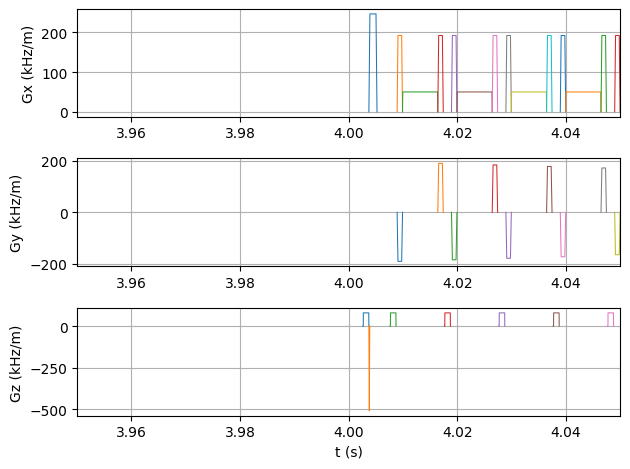

In [14]:
#@title interactive plot of latest seq
time_range=(3.95,4.05)

print('Current time range:',time_range)
seq.plot(time_range=time_range)
plt.show()